<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/Pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

# Loading CityScape Dataset from Berkely Server:

In [2]:
dataset_name = "cityscapes"

In [3]:
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

In [4]:
path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", 
                                      origin = _URL, 
                                      extract = True)
path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

103456768/103441232 [==============================] - 27s 0us/step


In [5]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/cityscapes'),
 PosixPath('/root/.keras/datasets/cityscapes.tar.gz')]

In [6]:
sample_image = tf.io.read_file(str(PATH/"train/1.jpg"))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


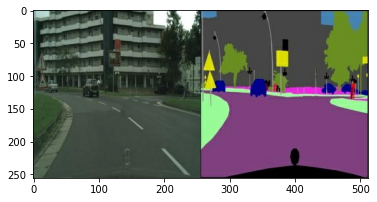

In [7]:
plt.figure()
plt.imshow(sample_image)

# Preprocessing:

In [11]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  width = tf.shape(image)[1] # get width of image
  width = width//2 # set width to 256
  semantic_seg_image = image[:, width:, :]
  driving_image = image[:, :width, :]
  
  driving_image = tf.cast(driving_image, tf.float16) # casting to float16 tensors
  semantic_seg_image = tf.cast(semantic_seg_image, tf.float16)

  return semantic_seg_image, driving_image

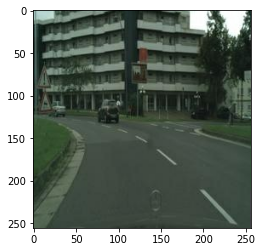

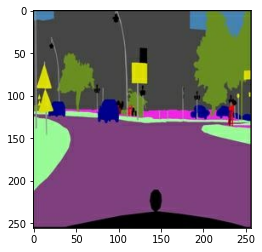

In [17]:
# inp=photo re=segmentation
re, inp = load(str(PATH/"train/1.jpg"))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(tf.cast(inp, tf.int16))
plt.figure()
plt.imshow(tf.cast(re, tf.int16))

In [18]:
BUFFER_SIZE = 2975
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [19]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [20]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [21]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [22]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

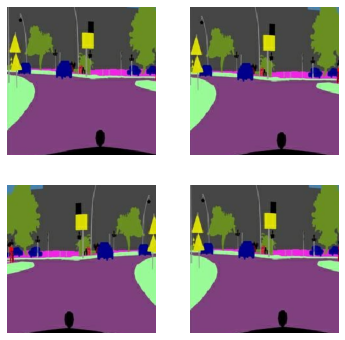

In [23]:
plt.figure(figsize=(6,6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2,2, i+1)
  plt.imshow(tf.cast(rj_re, tf.int16))
  plt.axis('off')
plt.show()

In [24]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image
  
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image 

In [25]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# U-Net Generator Implementation

In [ ]:
OUTPUT_CHANNELS = 3

In [37]:
# Encoder of U-Net 
def downsample(filters, size, apply_batchnorm=True):
  init = tf.random_uniform_initializer(minval=-0.02, maxval=0.02)
  res = tf.keras.Sequential()
  res.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
  
  if apply_batchnorm:
    res.add(tf.keras.layers.BatchNormalization())
  res.add(tf.keras.layers.LeakyReLU())
  return res

In [35]:
# Decoder of U-Net
def upsample(filters, size, apply_dropout=False):
  init = tf.random_uniform_initializer(minval=-0.02, maxval=0.02)
  res = tf.keras.Sequential()
  res.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
  res.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    res.add(tf.keras.layers.Dropout(0.5))
  res.add(tf.keras.layers.ReLU())
  return res

In [ ]:
# Generator construction
# start here tmw